In [1]:
!pip install bilby lalsuite

In [2]:
import lalsimulation as lalsim
import lal
import bilby
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

solar_mass = bilby.core.utils.constants.solar_mass
parsec = bilby.core.utils.constants.parsec

# Generating time domain waveforms and projecting them onto the detectors

In this notebook, I'll demonstrate how to use `lalsimulation` to generate a time-domain waveform and how to then use `bilby` to calculate the response of an interferometer.

## Setting a few things up

To get started, let's define some properties of the data we want to simulate. This is the sampling frequency, duration and the amount of time before and after the trigger time (roughly speaking, the peak of the 2,2 mode).


In [3]:
sampling_frequency = 4096
deltaT = 1 / sampling_frequency
duration = 4
post_trigger_duration = 0.5
pre_trigger_duration = duration - post_trigger_duration

## Generate a waveform

Now, we'll use `lalsim.SimInspiralChooseTDWaveform` to generate the plus and cross polarization

In [4]:
# Define the parameters in SI units
m1 = 30 * solar_mass
m2 = 30 * solar_mass
S1x, S1y, S1z = 0, 0, 0
S2x, S2y, S2z = 0, 0, 0
distance = 50e6 * parsec
inclination = 0
phiRef = 0
longAscNodes = 0
eccentricity = 0
meanPerAno = 0
LALParams = lal.CreateDict()

# Get the approximant number from the name
waveform_approximant = "IMRPhenomT"
approximant = lalsim.GetApproximantFromString(waveform_approximant)

# Estimate a minimum frequency required to ensure the waveform covers the data
# Note the 0.95 is a fudge factor as SimInspiralChirpStartFrequencyBound includes
# only the leading order Newtonian coefficient.
f_min = 0.95 * lalsim.SimInspiralChirpStartFrequencyBound(pre_trigger_duration, m1, m2)
if lalsim.SimInspiralGetSpinFreqFromApproximant(approximant) == lalsim.SIM_INSPIRAL_SPINS_FLOW:
    f_ref = f_min
else:
    f_ref = 20

h_plus_timeseries, h_cross_timeseries = lalsim.SimInspiralChooseTDWaveform(
    m1, m2, S1x, S1y, S1z, S2x, S2y, S2z, distance, inclination, phiRef, 
    longAscNodes, eccentricity, meanPerAno, deltaT, f_min, f_ref, LALParams,
    approximant
)

## Extract the data

In [5]:
h_plus = h_plus_timeseries.data.data
h_cross = h_cross_timeseries.data.data
h_plus_time = np.arange(len(h_plus)) * h_plus_timeseries.deltaT + float(h_plus_timeseries.epoch)
h_cross_time = np.arange(len(h_cross)) * h_cross_timeseries.deltaT + float(h_cross_timeseries.epoch)

## Project onto the Hanford interferometer

In [6]:
ra = 1.2
dec = -3.1
geocent_time = 1126259462.1
psi = 0.5
H1 = bilby.gw.detector.get_empty_interferometer("H1")

plus_polarization_tensor = bilby.gw.utils.get_polarization_tensor(ra, dec, geocent_time, psi, "plus")
f_plus = np.einsum('ij,ij->', H1.detector_tensor, plus_polarization_tensor)

cross_polarization_tensor = bilby.gw.utils.get_polarization_tensor(ra, dec, geocent_time, psi, "cross")
f_cross = np.einsum('ij,ij->', H1.detector_tensor, cross_polarization_tensor)

strain = f_plus * h_plus + f_cross * h_cross
strain_time = h_plus_time

## Plot the data

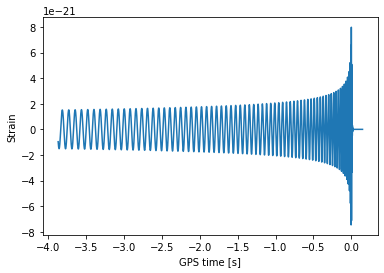

In [7]:
plt.plot(strain_time, strain)
plt.ylabel("Strain")
plt.xlabel(f"GPS time [s]")
plt.show()

From the plot above (or by inspecting `strain` and `strain_time`), we see that `SimInspiralChooseTDWaveform` outputs the strain on a grid of times with sampling frequency `1/deltaT`, but that the duration is determined by `f_min` and that peak of the 2,2 mode occurs at `0`.

We can translate this to the time measured by a detector by simply adding `geocent_time`, e.g.

In [8]:
strain_detector_time = strain_time + geocent_time

But, we'll want to compare our predicted strain with a timeseries of detector data which will be sampled on a different grid (even if the sampling frequency is identical, we would not expect a sampled timeseries to align with the peak of the 2,2 mode!). To convert, we can interpolate.

## Interpolate onto a sampled data grid


In [9]:
n = sampling_frequency * duration
data_start_time = int(geocent_time) - pre_trigger_duration
data_detector_time = np.arange(n) / sampling_frequency + data_start_time 
h_interp = interp1d(strain_detector_time, strain, fill_value=0, bounds_error=False)(data_detector_time)

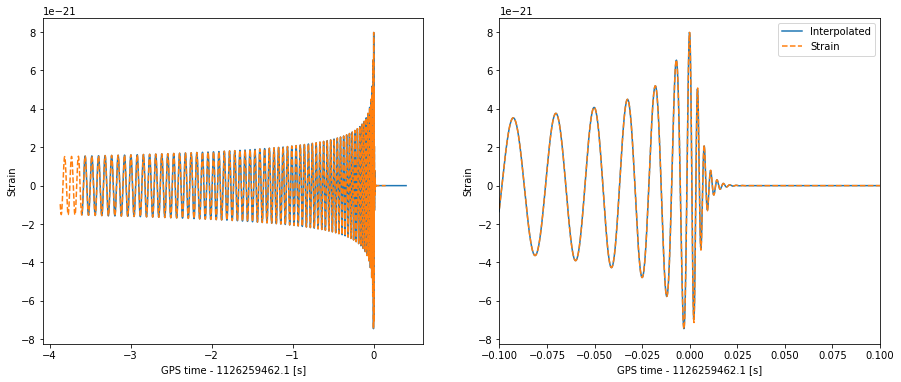

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
ax1.plot(data_detector_time - geocent_time, h_interp)
ax1.plot(strain_detector_time - geocent_time, strain, "--")
ax1.set_ylabel("Strain")
ax1.set_xlabel(f"GPS time - {geocent_time} [s]")
ax2.plot(data_detector_time - geocent_time, h_interp, label="Interpolated")
ax2.plot(strain_detector_time - geocent_time, strain, "--", label="Strain")
ax2.set_ylabel("Strain")
ax2.set_xlabel(f"GPS time - {geocent_time} [s]")
ax2.set_xlim(-0.1, 0.1)
ax2.legend()
plt.show()

## Putting it all together into a single function

In [11]:
def get_gw_waveform(time, parameters, waveform_approximant, reference_frequency, bilby_detector, fudge=0.95):

    # Extract information about the time series
    deltaT = time[1] - time[0]
    duration = time[-1] - time[0]
    nearest_trigger_idx = np.argmin(np.abs(time - parameters["geocent_time"]))
    pre_trigger_duration = time[nearest_trigger_idx] - time[0]
    
    # Get the approximant number from the name
    approximant = lalsim.GetApproximantFromString(waveform_approximant)

    # Estimate a minimum frequency required to ensure the waveform covers the data
    # Note the 0.95 is a fudge factor as SimInspiralChirpStartFrequencyBound includes
    # only the leading order Newtonian coefficient.
    f_min = 0.95 * lalsim.SimInspiralChirpStartFrequencyBound(pre_trigger_duration, m1, m2)
    
    # Check if the reference frequency is used, if not use f_min
    if lalsim.SimInspiralGetSpinFreqFromApproximant(approximant) == lalsim.SIM_INSPIRAL_SPINS_FLOW:
        f_ref = f_min
    elif reference_frequency == "fmin":
        f_ref = f_min
    else:
        f_ref = reference_frequency
        
    params, _ = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters(parameters)

    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=params["theta_jn"], phi_jl=params["phi_jl"], tilt_1=params["tilt_1"], tilt_2=params["tilt_2"],
        phi_12=params["phi_12"], a_1=params["a_1"], a_2=params["a_2"], mass_1=params["mass_1"], mass_2=params["mass_2"],
        reference_frequency=f_ref, phase=params["phase"])

    if "zenith" in params and "azimuth" in params:
        params["ra"], params["dec"] = bilby.gw.utils.zenith_azimuth_to_ra_dec(
            params['zenith'], params['azimuth'], params["geocent_time"], inputs.reference_frame)

    longAscNodes = 0
    eccentricity = 0
    meanPerAno = 0
    LALParams = lal.CreateDict()

    h_plus_timeseries, h_cross_timeseries = lalsim.SimInspiralChooseTDWaveform(
        m1, m2, S1x, S1y, S1z, S2x, S2y, S2z, distance, inclination, phiRef, 
        longAscNodes, eccentricity, meanPerAno, deltaT, f_min, f_ref, LALParams,
        approximant
    )

    plus_polarization_tensor = bilby.gw.utils.get_polarization_tensor(ra, dec, geocent_time, psi, "plus")
    f_plus = np.einsum('ij,ij->', H1.detector_tensor, plus_polarization_tensor)

    cross_polarization_tensor = bilby.gw.utils.get_polarization_tensor(ra, dec, geocent_time, psi, "cross")
    f_cross = np.einsum('ij,ij->', H1.detector_tensor, cross_polarization_tensor)


    h_plus = h_plus_timeseries.data.data
    h_cross = h_cross_timeseries.data.data
    h_plus_time = np.arange(len(h_plus)) * h_plus_timeseries.deltaT + float(h_plus_timeseries.epoch)

    h = f_plus * h_plus + f_cross * h_cross
    t = h_plus_time + geocent_time

    h_interp = interp1d(t, h, fill_value=0, bounds_error=False)(time)
    if h_interp[0] == 0:
        raise ValueError("Generated waveform was too short")
    return h_interp



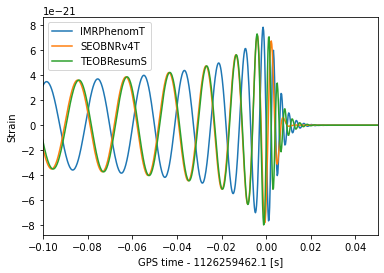

In [12]:
parameters = dict(
    mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=2000., theta_jn=0.4, psi=2.659,
    phase=2.8, geocent_time=1126259642.413, ra=1.375, dec=-1.2108
)

for waveform in ["IMRPhenomT", "SEOBNRv4T", "TEOBResumS"]:
    w = get_gw_waveform(data_detector_time, parameters, waveform, "fmin", H1)
    plt.plot(data_detector_time - geocent_time, w, label=waveform)
plt.xlim(-0.1, 0.05)
plt.ylabel("Strain")
plt.xlabel(f"GPS time - {geocent_time} [s]")
plt.legend()
plt.show()

## Time the generation

In [13]:
prior = bilby.gw.prior.BBHPriorDict()
prior["geocent_time"] = bilby.core.prior.Uniform(geocent_time - 0.1, geocent_time + 0.1)

08:59 bilby INFO    : No prior given, using default BBH priors in /home/greg/bilby/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [14]:
%%timeit
_ = get_gw_waveform(data_detector_time, prior.sample(), "SEOBNRv4T", 20, H1, fudge=0.95)


415 ms ± 7.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
_ = get_gw_waveform(data_detector_time, prior.sample(), "IMRPhenomT", 20, H1, fudge=0.95)

5.82 ms ± 96.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
_ = get_gw_waveform(data_detector_time, prior.sample(), "IMRPhenomD", 20, H1, fudge=0.95)

6.57 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
